In [1]:
import pandas as pd
import numpy as np
import csv
from tqdm import tqdm
import itertools
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import date
from os.path import join, isfile
from os import listdir
import time
import seaborn as sns

In [2]:
def read_rep(kdv_csv, ID_csv, low_age, high_age, data_dir):
    
    # open directories
    kdv_dir = data_dir+"\\kdv-patients-age-group-"+str(low_age) + "-" + str(high_age)
    ID_dir = data_dir+ "\\kdv-selected-ID-controls-age-group-"+str(low_age) + "-" + str(high_age)

    # get list of filenames
    files_kdv = [f for f in listdir(kdv_dir) if (isfile(join(kdv_dir, f)) & ("crop_sized.jpg" in f))]
    files_ID = [f for f in listdir(ID_dir) if (isfile(join(ID_dir, f)) & ("crop_sized.JPG" in f))]
    
    data = []
    labels = []

    for i, csv_file in enumerate([ID_csv, kdv_csv]):
        with open (csv_file, newline='') as file:
            reader = csv.reader(file, delimiter=',')
            for row in reader:
                if row[0] in files_kdv or row[0] in files_ID:
                    rep = list(map(float, row[1:]))
                    data.append(rep)
                    labels.append(i)
    
    return np.array(data), np.array(labels)

In [3]:
def normalize(data, i):

    if i == 0:
        return data
    
    if i == 1:
        return Normalizer().fit_transform(data)
        
    if i == 2:
        return StandardScaler().fit_transform(data)

### Method 4: Gradient Boosting classifier

In [4]:
def gr_classifier(data, labels):
    best_aroc = 0
    estimators = [20] #, 40, 60, 80]
    best_estimator_gr = 0
    best_norm = -1

    for est in tqdm(estimators):
        for i in [1, 2]:
            
            data = normalize(data, i) 
            all_y, all_probs, all_preds = [], [], [] 
            loo = LeaveOneOut()
            
            # leave one out split and make prediction
            for train, test in loo.split(data):
                all_y.append(labels[test])
                model = GradientBoostingClassifier(n_estimators=est)
                model = model.fit(data[train], labels[train])
                all_probs.append(model.predict_proba(data[test].reshape(1, -1))[:,1])
                all_preds.append(model.predict(data[test].reshape(1, -1)))

            # based on all predictions make aroc curve and confusion matrix
            aroc = roc_auc_score(all_y, all_probs)
            tn, fp, fn, tp = confusion_matrix(all_y, all_preds).ravel()
            spec = tn / (tn+fp)  
            sens = tp / (tp+fn)
               
            if aroc > best_aroc:
                best_aroc, best_spec, best_sens, best_norm = aroc, spec, sens, i 
                best_estimator_gr = est
                
            if best_aroc > 0.8:
                print("tn {}, fp {}, fn {}, tp {}".format(tn, fp, fn, tp))
                print("aroc: {}".format(aroc))
                print("best_aroc: {} , spec: {}, sens: {}".format(best_aroc, spec, sens))
                print("trees: {}, norm: {}".format(best_estimator_gr, best_norm))
                conf_matrix = [[tp, fp],
                             [fn, tn]]
                df_cm = pd.DataFrame(conf_matrix, index = ["Kdvs_pred", "Control_pred"], columns = ["Kdvs", "Control"])
                plt.figure(figsize = (6, 6))
                sns_heat = sns.heatmap(df_cm, annot=True)
                plt.show()                
                
                                
    return best_estimator_gr, best_norm, best_aroc, best_spec, best_sens

In [5]:
def concatenate(data_df, labels_df, data_dlib, labels_dlib, data_combination, nr_feats):
    # assert data has same shape and labels are exactly the same
    assert data_df.shape[0] == data_dlib.shape[0]
    assert labels_df.shape == labels_dlib.shape
    match = [True for i, j in zip(labels_df, labels_dlib) if i == j]
    assert False not in match

    if data_combination == 2 or data_combination == 3 or data_combination == 4:
        # deepface + dlib (all features) 
        data, labels  = [], []
        for index, (df_i, dlib_i) in enumerate(zip(data_df, data_dlib)):
            if len(dlib_i) == 2210: #3110: 
                #only if a face is found (otherwise there a fewer zeros)
                data.append(df_i.tolist()+dlib_i) # concatenation of 4096 deepface + 2210 dlib
                labels.append(labels_df[index])
    
    return 0, np.array(data), np.array(labels)
    

  0%|                                                    | 0/1 [00:00<?, ?it/s]

tn 50, fp 20, fn 15, tp 51
aroc: 0.821861471861472
best_aroc: 0.821861471861472 , spec: 0.7142857142857143, sens: 0.7727272727272727
trees: 20, norm: 1


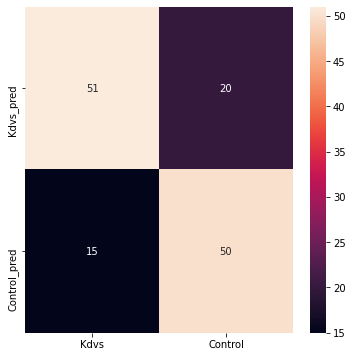

tn 50, fp 20, fn 17, tp 49
aroc: 0.8365800865800865
best_aroc: 0.8365800865800865 , spec: 0.7142857142857143, sens: 0.7424242424242424
trees: 20, norm: 2


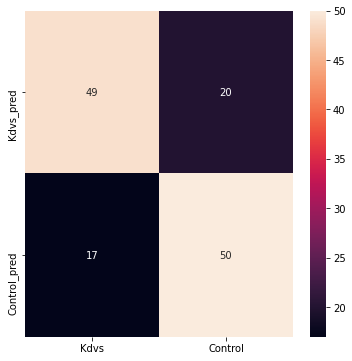

100%|███████████████████████████████████████████| 1/1 [07:53<00:00, 473.84s/it]

done running main file


In [6]:
def main():    

    data_dir = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\kdv" 

    data_combination =  2
    low_age = 1
    high_age = 40
    
    method = "dlib"
    kdv_csv = data_dir+"\\representations\kdv-patients-"+method+".csv"  
    ID_csv  = data_dir+"\\representations\ID-controls-"+method+".csv"
    data_dlib, labels_dlib = read_rep(kdv_csv, ID_csv, low_age, high_age, data_dir)

    method = "deepface"
    kdv_csv = data_dir+"\\representations\kdv-patients-"+method+".csv"  
    ID_csv  = data_dir+"\\representations\ID-controls-"+method+".csv"
    data_df, labels_df = read_rep(kdv_csv, ID_csv, low_age, high_age, data_dir)

    # data, labels depend on data_combination
    nr_comps, data, labels = concatenate(data_df, labels_df, data_dlib, labels_dlib, data_combination, 0)
    n_trees_gr, gr_norm, gr_aroc, gr_spec, gr_sens = gr_classifier(data, labels)

    print("done running main file")
    
main()
    